# LSTM Time-Series Forecasting for SPY ETF
**Project:** Time-series forecasting for equities using LSTM

**Author:** Khalid Hajeer

**Last updated:** August 14, 2025

## Table of Contents
1. [Introduction](#1-introduction)
2. [Libraries](#2-libraries)  
3. [Data Collection & Preprocessing](#3-data-collection--preprocessing)  
4. [Exploratory Data Analysis (EDA)](#4-exploratory-data-analysis-eda)  
5. [Feature Engineering](#5-feature-engineering)
6. [Systematic Feature Selection](#6-systematic-feature-selection)  
7. [LSTM Model Architecture & Data Preparation](#7-lstm-model-architecture--data-preparation)  
8. [Model Training](#8-final-model-training)
9. [Results & Diagnostics](#9-results--diagnostics)
10. [Conclusion](#10-conclusion)

## 1. Introduction

The **SPDR S&P500 ETF Trust (SPY)** tracks the performance of the S&P500 index - a benchmark of 500 leading publicly listed companies in the United States. 

SPY is one of the most traded ETFs globally and is often used as a proxy for the overall U.S. stock market.
- **SPY annualised return since inception (1993)**: ~9.3%
- **S&P 500 annualised return with dividends reinvested**: ~10.62% (~7.44% after inflation)

Time-series prediction in finance is inherently challenging, as it involves using the past to forecast the future.
The uncertainty of markets makes this both difficult and intellectually stimulating - using the belief that past patterns, though never perfectly repeating, can sometimes offer fortune-telling powers.

### Objectives
Our goal is to **build and evaluate a Long Short-Term Memory (LSTM)** network - a type of Recurrent Neural Network (RNN) - to predict the **next-day closing price of SPY**
We will predict the **daily return** rather than the raw closing price, as returns are generally more stationary and have a more stable distribution over time. This stability helps the model detect patterns more effectively and avoids issues that arise from the strong trends and non-stationarity of raw price data.
$$
dailyreturn = \frac{todayclose - yesterdayclose}{yesterdayclose} = close.pctchange()
$$
From the predicted daily return, we calculate the closing price:
$$
tomorrowclose = todayclose \times (1 + dailyreturn)
$$

### Methodology Overview
**1. Libraries** - import all necessary Python libraries and packages used throughout the notebook

**2. Data Collection & Preprocessing** - retrieve OHLCV (Open, High, Low, Close, Volume) data from ALPACA API and organise it into a usable DataFrame format

**3. Exploratory Data Analysis (EDA)** - inspect and visualise the data to understand patterns, trends, and any anomalies

**4. Feature Engineering** - create and add derived features that may help improve the model's predictive performance

**5. Systematic Feature Selection** - use a Random Forest model to rank features by importance and select the most relevant ones

**6. LSTM Model Architecture & Data Preparation** - prepare the dataset and define the architecture of the LSTM model

**7. Final Model Training & Evaluation** - train the tuned LSTM model on the training data and evaluate its performance on the test set

**8. Results & Diagnostics** - visualise predictions vs actual values, calculate metrics (RMSE, MAE), and analyse errors

**9. Conclusion** - summarise findings, discuss limitations, and suggest next steps or improvements.

### Why LSTM?
LSTMs capture patterns in sequential and temporal data by learning which parts of past information are most relevant for future predictions. They are a type of Recurring Neural Network (RNN) designed to overcome the vanishing gradient problem, where gradients become extremely small during backpropagation through time, making it difficult for standard RNNs to learn long-term dependencies.
By incoporating gating mechanisms, LSTMs can retain important information over longer sequences, making them particularly suited for stock market time-series forecasting.

### Scope & Assumptions
- This approach can be adapted to any stock symbol supported by Alpaca, though model performance will vary
- Users must adjust for stock splits and corporate actions (e.g., mergers, spin-offs, or ticker symbol changes) when applying this approach to other securities
- Predictions are based solely on historical OHLCV and engineered features - no macroeconomic data is included

### Expected Output
By the end of this notebook, we will have:
- A trained LSTM model for predicting next-day SPY closing prices
- Visualisations comparing actual vs. predicted prices
- Performance metrics (e.g., RMSE, MAE) for model evaluation
- A one-step ahead forecast for SPY's closing price tomorrow


### Financial Disclaimer
This project is for **educational purposes only** and is not **financial advice**. Predicted prices are merely guesses made by the model and are not 100% certain.

> "If you were to give a monkey a typewriter and let him randomly hit keys forever, then he would eventually type Shakespeare's Hamlet - word for word."

## 2. Libraries

In [36]:
# Core Libraries 
import pandas as pd
import numpy as np
import os
from dotenv import load_dotenv
from datetime import datetime

# Machine Learning Libraries
import tensorflow as tf
from tensorflow import keras
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

# Visualization Libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Alpaca Libraries
from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame

# Statistical Libraries
from scipy.stats import entropy
from statsmodels.tsa.stattools import acf

## 3. Data Collection & Preprocessing

First, we'll load our API credentials and fetch the data from Alpaca. The data is requested for a wide date range to ensure we have a large dataset for training and testing our model.

In this section, we will collect, clean, and prepare the historical stock price data for our analysis. We will use the Alpaca API to get daily stock prices for SPY.

In [37]:
# Load environment variables from a .env file
load_dotenv()

# Initialise the Alpaca API client with credentials
client = StockHistoricalDataClient(
    os.getenv('ALPACA_API_KEY'), 
    os.getenv('ALPACA_SECRET_KEY')    
)

# Define the parameters for the data request
request_params = StockBarsRequest(
    symbol_or_symbols=["SPY"],
    timeframe=TimeFrame.Day,
    start=datetime(2015, 8, 1),
    end=datetime(2025, 8, 1)
)
# Fetch the stock data from the Alpaca API
bars = client.get_stock_bars(request_params)

# Convert the data into a pandas DataFrame
df = bars.df.reset_index()

Next, we will perform a quick data quality check. It's crucial to verify that our new DataFrame has no missing values or duplicate entries before we proceed with any analysis or feature engineering.

In [38]:
# Ensure 'timestamp' is in datetime format and set as index
df['timestamp'] = pd.to_datetime(df['timestamp'])
df.set_index('timestamp', inplace=True)

In [39]:
# Remove duplicates if any exist
duplicates_count = df.duplicated().sum()
if duplicates_count > 0:
    df.drop_duplicates(inplace=True)
    print(f"\nRemoved {duplicates_count} duplicate rows")
    
# Check for missing values (NaNs) before filling
print(f"Missing values in each column: {df.isnull().sum()}")

# Fill missing values using time-based linear interpolation
df.interpolate(method='time', inplace=True)

# Verify missing values after interpolation
print(f"\nMissing values after interpolation: {df.isnull().sum()}")

Missing values in each column: symbol         0
open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
dtype: int64

Missing values after interpolation: symbol         0
open           0
high           0
low            0
close          0
volume         0
trade_count    0
vwap           0
dtype: int64


/var/folders/l9/zmdgypk569x7yf8ttvk8fsbw0000gp/T/ipykernel_823/3555817586.py:11: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df.interpolate(method='time', inplace=True)


Finally, let's inspect the data and set up the timestamp column as the DataFrame's index. This is a standard and necessary step for time-series analysis, making plotting and data manipulation more intuitive.

## 4. Exploratory Data Analysis (EDA)

In this section, we'll dive into the dataset to understand its structure and uncover initial insights. We will look at the first few rows of the data, check the data types of each column, and compute some basic descriptive statistics. This will help us get a feel for the data before we start modeling.

In [40]:
# Display the first 5 rows of the DataFrame to get a quick overview of the data
print("Head of DataFrame:")
display(df.head())

# Print a concise summary of the DataFrame
print("\n DataFrame Info:")
df.info()

# Generate descriptive statistics
print("\n DataFrame Descriptive Statistics:")
display(df.describe())

Head of DataFrame:


,symbol,open,high,low,close,volume,trade_count,vwap
timestamp,,,,,,,,
2016-01-04 05:00:00+00:00,SPY,200.490,201.03,198.59,201.0192,225903783.0,655489.0,199.753436
2016-01-05 05:00:00+00:00,SPY,201.405,201.90,200.05,201.3600,112719152.0,418709.0,201.085380
2016-01-06 05:00:00+00:00,SPY,198.330,200.06,197.60,198.8200,153948196.0,548386.0,198.839872
2016-01-07 05:00:00+00:00,SPY,195.330,197.44,193.59,194.0500,216191953.0,796451.0,195.202134
2016-01-08 05:00:00+00:00,SPY,195.190,195.85,191.58,191.9230,216105404.0,754102.0,193.673322



 DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2408 entries, 2016-01-04 05:00:00+00:00 to 2025-07-31 04:00:00+00:00
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   symbol       2408 non-null   object 
 1   open         2408 non-null   float64
 2   high         2408 non-null   float64
 3   low          2408 non-null   float64
 4   close        2408 non-null   float64
 5   volume       2408 non-null   float64
 6   trade_count  2408 non-null   float64
 7   vwap         2408 non-null   float64
dtypes: float64(7), object(1)
memory usage: 169.3+ KB

 DataFrame Descriptive Statistics:


,open,high,low,close,volume,trade_count,vwap
count,2408.000000,2408.000000,2408.000000,2408.000000,2.408000e+03,2.408000e+03,2408.000000
mean,363.512085,365.529068,361.326200,363.588241,8.408297e+07,4.810008e+05,363.504396
std,116.009696,116.596704,115.338378,116.028180,4.206000e+07,3.242417e+05,115.991136
min,182.340000,184.100000,181.020000,182.860000,2.055010e+07,8.430700e+04,182.644101
25%,268.070000,270.187500,266.836250,268.275000,5.836328e+07,2.790508e+05,268.181600
50%,343.620000,347.590000,342.335000,343.905000,7.435667e+07,4.168990e+05,344.357596
75%,442.135000,444.057500,439.292500,442.212500,9.686542e+07,5.880490e+05,441.868306
max,639.455000,639.850000,635.540000,637.100000,3.948250e+08,3.709929e+06,636.840101


Next, we will visualise the closing price and trading volume over time. These plots will help us to spot trends, patterns, and potential anomalies in the data across its entire history.

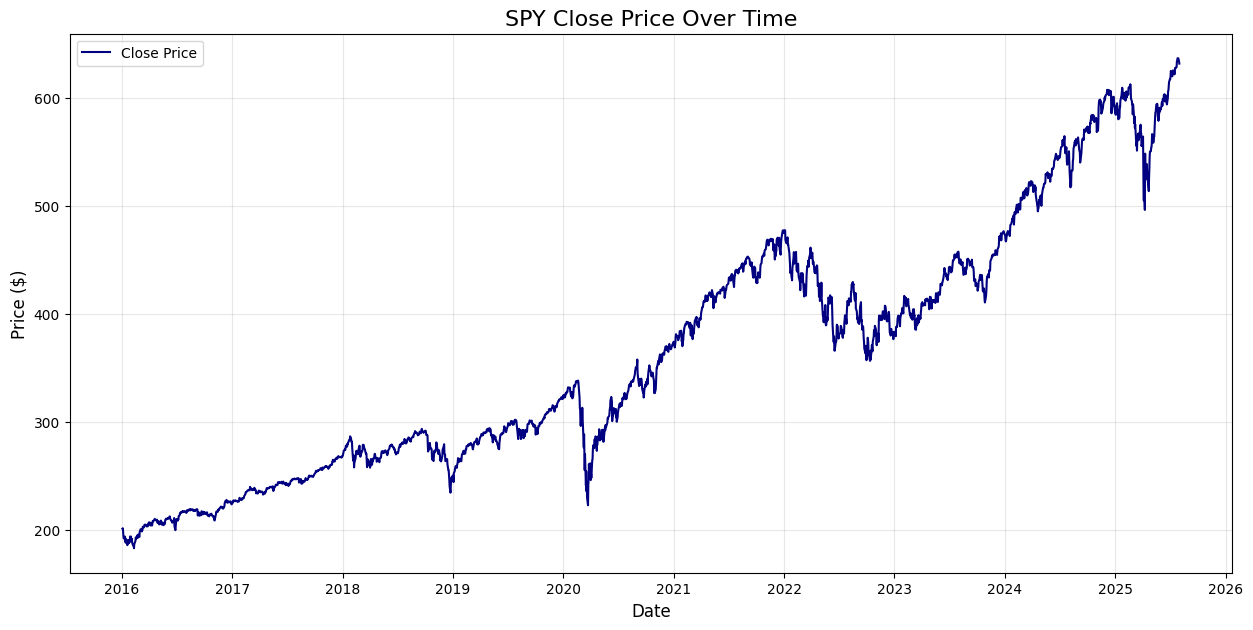

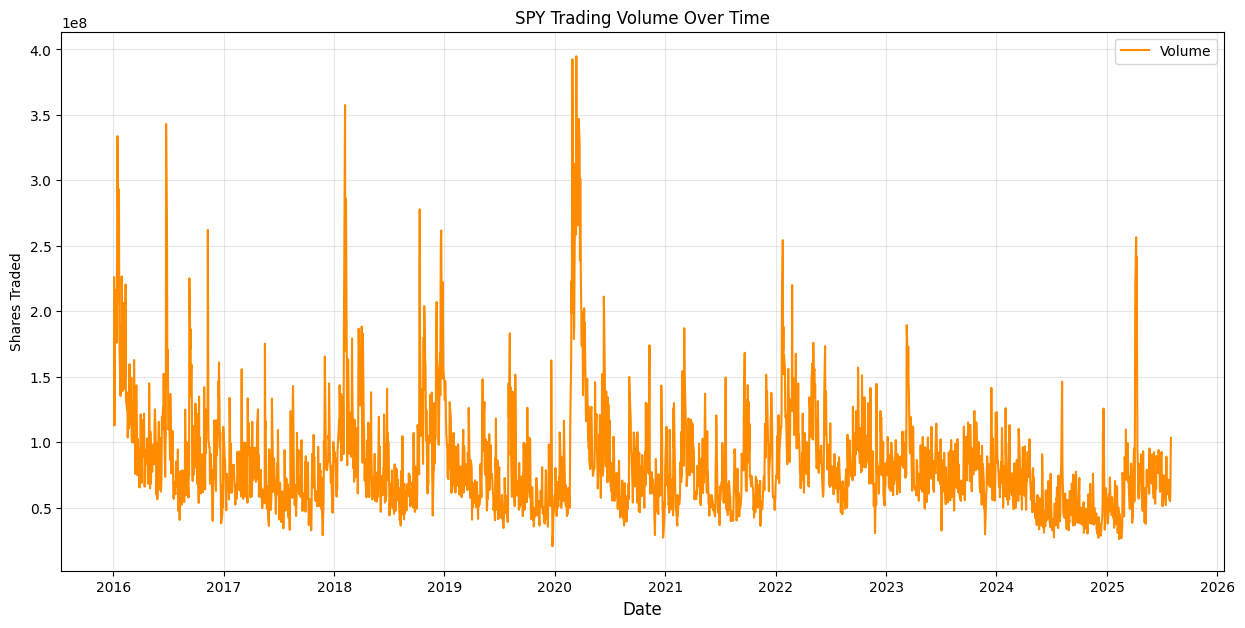

In [41]:
# Plot the close price over time
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['close'], label='Close Price', color='navy')
plt.title('SPY Close Price Over Time', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price ($)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Plot the volume over time
plt.figure(figsize=(15, 7))
plt.plot(df.index, df['volume'], label='Volume', color='darkorange')
plt.title('SPY Trading Volume Over Time')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Shares Traded')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## 5. Feature Engineering

In financial time series prediction, engineered features often carry more predictive power than directly modelling OHLCV. By transforming the original data into domain-relevant indicators, we can help the model capture trends, momentum, and volatility patters more effectively.
Here, we create a range of ~40 features including lagged prices, daily returns, and technical indicators, as well as statistical measures such as Shannon entropy and the Hurst exponent.

**Why daily return instead of raw price?**
The **daily return** is given by:
$$
R_t = \frac{P_t - P_{t-1}}{P_{t-1}}
$$

where
- $P_t$ is today's close price 
- $P_{t-1}$ is yesterday's close price

We predict returns rather than prices because returns tend to have a smaller range andexhibit more stationarity, making them easier for models to learn.

### 5.1 Price-Based Features

We begin by generating basic transformations of open, high, low, and close to give the model awareness of price structure and returns.

In [42]:
# Lag features
df["close_lag_1"] = df["close"].shift(1)
df["close_lag_2"] = df["close"].shift(2)

# Price change features
df["close_minus_open"] = df["close"] - df["open"]
df["high_minus_low"] = df["high"] - df["low"]

# Ratio features
df["close_over_open"] = df["close"] / df["open"]
df["high_over_low"] = df["high"] / df["low"]
df["daily_return"] = df["close"].pct_change()

### 5.2 Technical Indicators

Here we compute standard indicators used in quantitative analysis, such as moving averages, RSI, MACD, Bollinger Bands, momentum and stochastic oscillators.
- **SMA (Simple Moving Average)**: Average of closing price over a window; helps identify trend direction.
- **EMA (Exponential Moving Average)**: Similar to SMA but gives more weight to recent prices; reacts faster to change.
- **RSI (Relative strength Index)**: Momentum indicator that measures recent gains vs. losses (0-100); detects overbough/oversold conditions.
- **MACD (Moving Average Convergence Divergence)**: Shows the difference between fast & slow EMAs; useful for trend strengnth and reversals.
- **Bollinger Bands**: Bands above/below SMA that expand/contract based on volatility; used to detect price extremes
- **Momentum**: Measures volatility of price changes; helps capture accelerations.
- **Stochastic Oscillator**: Compares closing price to recent highs/lows; signals potential reversals when crossing certain levels.
- **OBV (On-Balance Volume)**: Cumulative Volume that adds on up days and subtracts on down days; used to confirm trends

In [43]:
# Moving Averages (SMA and EMA)
df["SMA_10"] = df["close"].rolling(window=10).mean()
df["SMA_20"] = df["close"].rolling(window=20).mean()
df["EMA_20"] = df["close"].ewm(span=20).mean()
df["EMA_50"] = df["close"].ewm(span=50).mean()

# Volatility
df["volatility_10"] = df["daily_return"].rolling(window=10).std()
df["volatility_20"] = df["daily_return"].rolling(window=20).std()

# RSI (14-day period)
delta = df["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)
avg_gain = pd.Series(gain, index=df.index).rolling(window=14).mean()
avg_loss = pd.Series(loss, index=df.index).rolling(window=14).mean()
rs = avg_gain / avg_loss
df["RSI_14"] = 100 - (100 / (1 + rs))

# MACD & Signal Line
EMA_12 = df["close"].ewm(span=12).mean()
EMA_26 = df["close"].ewm(span=26).mean()
df["MACD"] = EMA_12 - EMA_26
df["MACD_signal"] = df["MACD"].ewm(span=9).mean()

# Bollinger Bands
df["BB_upper"] = df["SMA_20"] + (2 * df["close"].rolling(window=20).std())
df["BB_lower"] = df["SMA_20"] - (2 * df["close"].rolling(window=20).std())

# Momentum 
df["momentum_5"] = df["close"] - df["close"].shift(5)

# Stochastic Oscillator 
low_14 = df["low"].rolling(window=14).min()
high_14 = df["high"].rolling(window=14).max()
df["stochastic_14"] = (df["close"] - low_14) / (high_14 - low_14) * 100


### 5.3 Volatility & Rolling Statistics

We use rolling statistics to capture trends in market volatility and relative deviation.

In [44]:
# Rolling standard deviation 
df["rolling_std_5"] = df["close"].rolling(window=5).std()
df["rolling_std_10"] = df["close"].rolling(window=10).std()
df["rolling_std_20"] = df["close"].rolling(window=20).std()

# Rolling mean 
df["rolling_mean_5"] = df["close"].rolling(window=5).mean()
df["rolling_mean_10"] = df["close"].rolling(window=10).mean()
df["rolling_mean_20"] = df["close"].rolling(window=20).mean()

# Z-score
df["zscore_close_10"] = (df["close"] - df["rolling_mean_10"]) / df["rolling_std_10"]

### 5.4 Volume-Based Features

Volume patterns can be strong predictors of price action. Here we include lagged volume, changes, and VWAP deviations.

In [45]:
df["volume_lag_1"] = df["volume"].shift(1)
df["volume_change"] = df["volume"].pct_change()
df["volume_over_rolling_avg_10"] = df["volume"] / df["volume"].rolling(window=10).mean()

df["vwap_diff"] = df["close"] - df["vwap"]
df["vwap_ratio"] = df["close"] / df["vwap"]

df["trade_count_change"] = df["trade_count"].pct_change()

# On-Balance Volume (OBV)
obv = [0] # Initialize OBV list
for i in range(1, len(df)):
    if df['close'][i] > df['close'][i-1]:
        obv.append(obv[-1] + df['volume'][i])
    elif df['close'][i] < df['close'][i-1]:
        obv.append(obv[-1] - df['volume'][i])
    else:
        obv.append(obv[-1])
df['OBV'] = obv

/var/folders/l9/zmdgypk569x7yf8ttvk8fsbw0000gp/T/ipykernel_823/3574298622.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  if df['close'][i] > df['close'][i-1]:
/var/folders/l9/zmdgypk569x7yf8ttvk8fsbw0000gp/T/ipykernel_823/3574298622.py:14: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  obv.append(obv[-1] + df['volume'][i])
/var/folders/l9/zmdgypk569x7yf8ttvk8fsbw0000gp/T/ipykernel_823/3574298622.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, u

### 5.5 Statistical Features

These features attempt to extract hidden structures, periodicity, and randomness from the time series - often useful in regime detection, anomaly spotting, and advanced modeling.

- **shannon Entropy**: Measures the degree of randomness in a distribution. High entropy suggests noise or unpredictability, while low entropy implies more structure.
- **Hurst Exponent**: Estimates the long-term memory of a series. A value > 0.5 implies trending behaviour, < 0.5 suggests mean-reverting tendencies, and ~0.5 indicates a random walk.
- **Autocorrelation (Lag 1)**: Measures the correlation between a value and its lagged version. High autocorrelation can indicate persistence or seasonality. 

In [ ]:
# Shannon Entropy of Close Price Over a Rolling Window
def shannon_entropy(series, bins=20):
    """Compute the Shannon entropy of a windowed series."""
    hist, _ = np.histogram(series.dropna(), bins=bins, density=True)
    return entropy(hist)

df["shannon_entropy_close"] = df["close"].rolling(window=20).apply(shannon_entropy, raw=False)

# Hurst Exponent Over a Rolling Window
def hurst_exponent(ts):
    """Estimate Hurst exponent of a time series segment."""
    if len(ts) < 20 or ts.isnull().any():
        return np.nan
    lags = range(2, 20)
    try:
        tau = [np.std(ts.values[lag:] - ts.values[:-lag]) for lag in lags]
        log_lags = np.log(lags)
        log_tau = np.log(tau)
        hurst = np.polyfit(log_lags, log_tau, 1)[0]
        return hurst
    except:
        return np.nan

df["hurst_exponent_close"] = df["close"].rolling(window=100).apply(hurst_exponent, raw=False)

# Rolling Autocorrelation (Lag 1 to 3)
df["autocorr_lag_1"] = df["close"].rolling(window=20).apply(lambda x: acf(x, nlags=1)[1], raw=False)
df["autocorr_lag_2"] = df["close"].rolling(window=20).apply(lambda x: acf(x, nlags=2)[2], raw=False)
df["autocorr_lag_3"] = df["close"].rolling(window=20).apply(lambda x: acf(x, nlags=3)[3], raw=False)


Now let's clean up the NaN values and look at the key details of our update DataFrame

In [47]:
# Drop initial rows with NaN values
df.dropna(inplace=True)

In [48]:
# Display the first 5 rows of the DataFrame to get a quick overview of the data
print("Head of DataFrame:")
print(df.head())

# Print a concise summary of the DataFrame
# This includes the index dtype and columns, non-null values, and memory usage
print("\n DataFrame Info:")
print(df.info())

# Generate descriptive statistics that summarise the central tendency, dispersion, and shape of the dataset's distribution
print("\n DataFrame Descriptive Statistics:")
print(df.describe())

Head of DataFrame:
                          symbol    open    high       low   close  \
timestamp                                                            
2016-05-25 04:00:00+00:00    SPY  208.67  209.77  207.8691  209.28   
2016-05-26 04:00:00+00:00    SPY  209.44  209.71  208.9700  209.34   
2016-05-27 04:00:00+00:00    SPY  209.53  210.25  209.4700  210.24   
2016-05-31 04:00:00+00:00    SPY  210.56  210.69  209.1800  209.84   
2016-06-01 04:00:00+00:00    SPY  209.12  210.48  208.8900  210.27   

                                volume  trade_count        vwap  close_lag_1  \
timestamp                                                                      
2016-05-25 04:00:00+00:00   80831278.0     290102.0  209.298202       207.87   
2016-05-26 04:00:00+00:00   56427942.0     206445.0  209.327290       209.28   
2016-05-27 04:00:00+00:00   65103644.0     239659.0  209.893491       209.34   
2016-05-31 04:00:00+00:00  115528767.0     351158.0  209.980504       210.24   
2016-06-01

### 5.6 Feature Visualisation

Now that we've engineered a rich set of features, it's important to visualise them. This helps us understand their distributions, correlations, and relationships with the closing price before feeding them into the model.

#### 5.6.1 Correlation Heatmap
This helps us see which features are most correlated with the 'close' price and identify any multicollinearity between features.

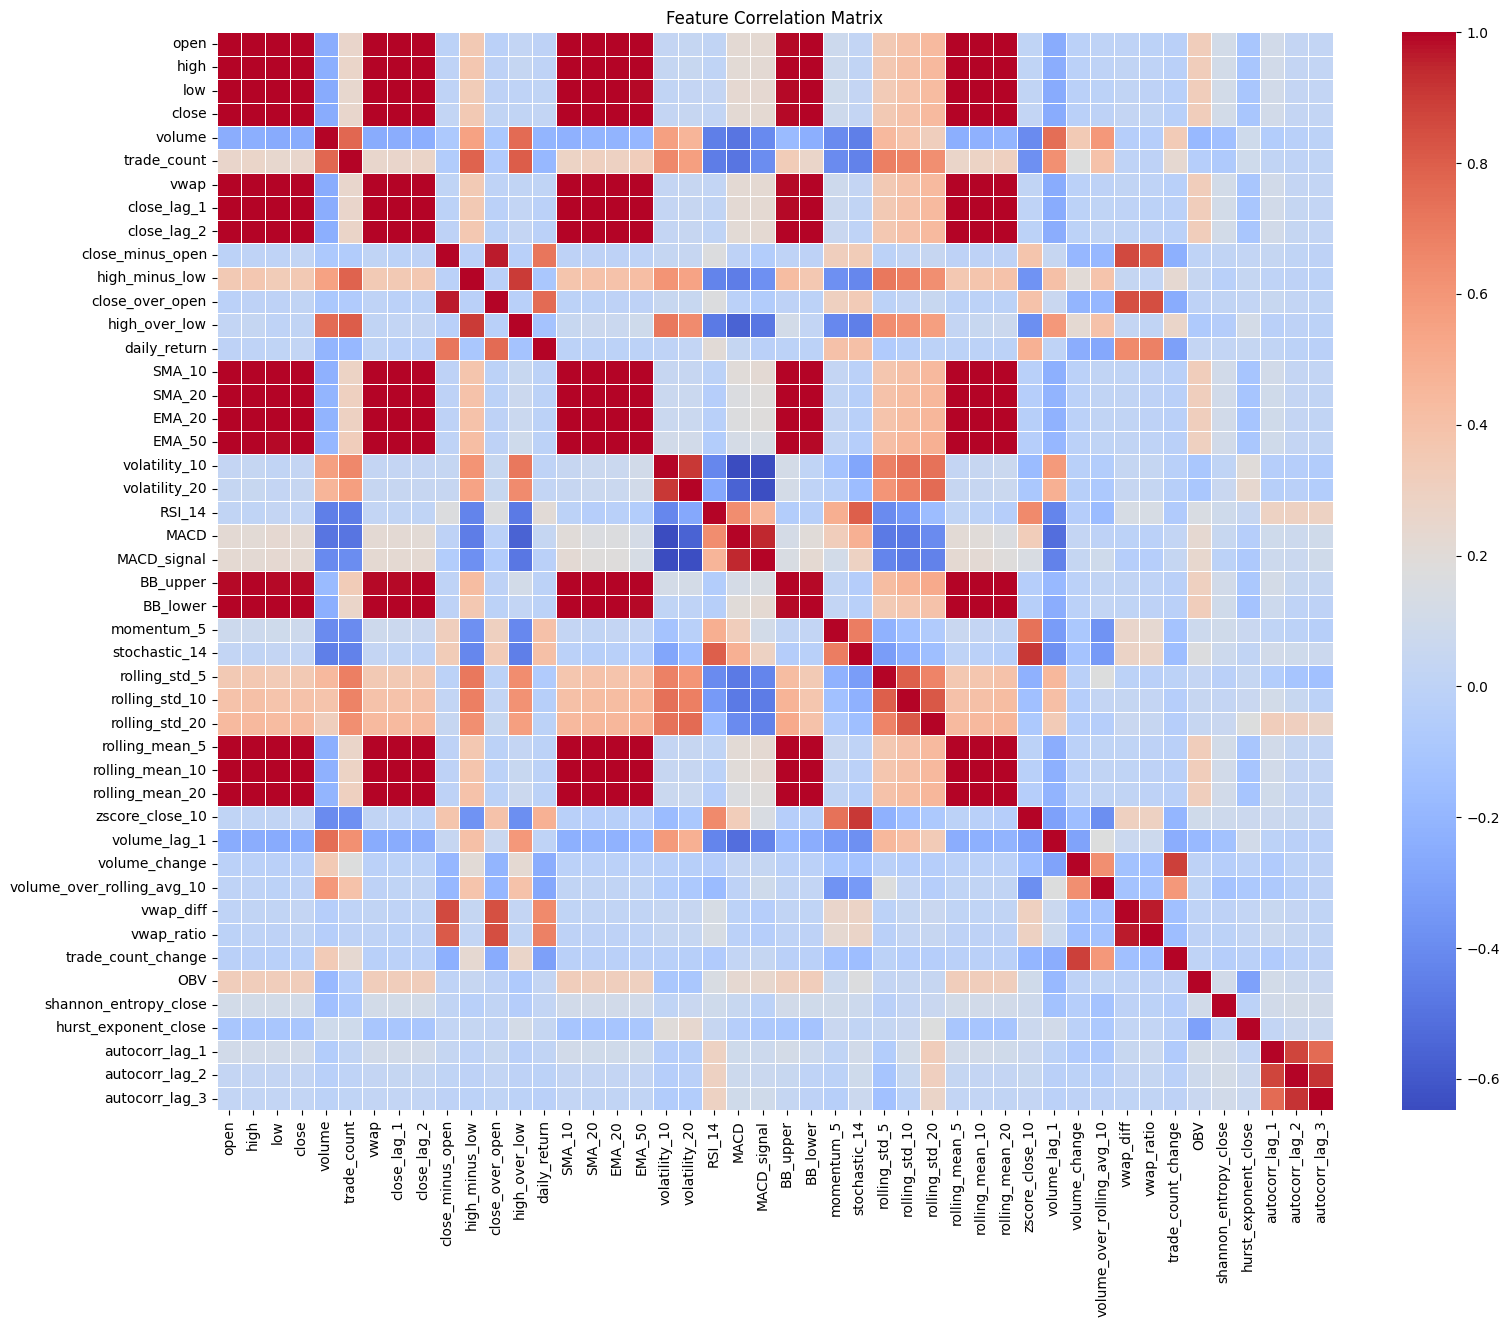


Top 10 features most correlated with 'close' price:
close              1.000000
vwap               0.999899
high               0.999751
low                0.999747
open               0.999556
close_lag_1        0.999292
rolling_mean_5     0.999213
close_lag_2        0.998692
rolling_mean_10    0.998266
SMA_10             0.998266
EMA_20             0.997389
Name: close, dtype: float64


In [49]:
plt.figure(figsize=(18,14))
correlation_matrix = df.corr(numeric_only=True)
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=.5)
plt.title('Feature Correlation Matrix')
plt.show()

print("\nTop 10 features most correlated with 'close' price:")
print(correlation_matrix['close'].abs().sort_values(ascending=False).head(11))

This heatmap gives us a quick overview of how our engineered features relate to each other. The colour scale indicates the strength of the linear correlation, from strong positive (red) to strong negative (blue).
- **High Multicollinearity (Bright Red Blocks):** As expected, price-based features like open, high, low, close, vwap, and all the moving averages are extremely corrclated with each other. This is normal since they are all derived from the price.
- **Informative Indicators:** Features like RSI_14, OBV, and volatility are not perfectly correlated with the close price. This is a good sign, as it suggests they are providing unique information (like momentum, volume pressure, and risk) that isn't captured by the price alone.

#### 5.6.2 Key Indicator Subplots
Plotting indicators like RSI & MACD below the price chart is a good way to visually inspect their behaviour in relation to price movements. We'll plot the last 500 days for clarity

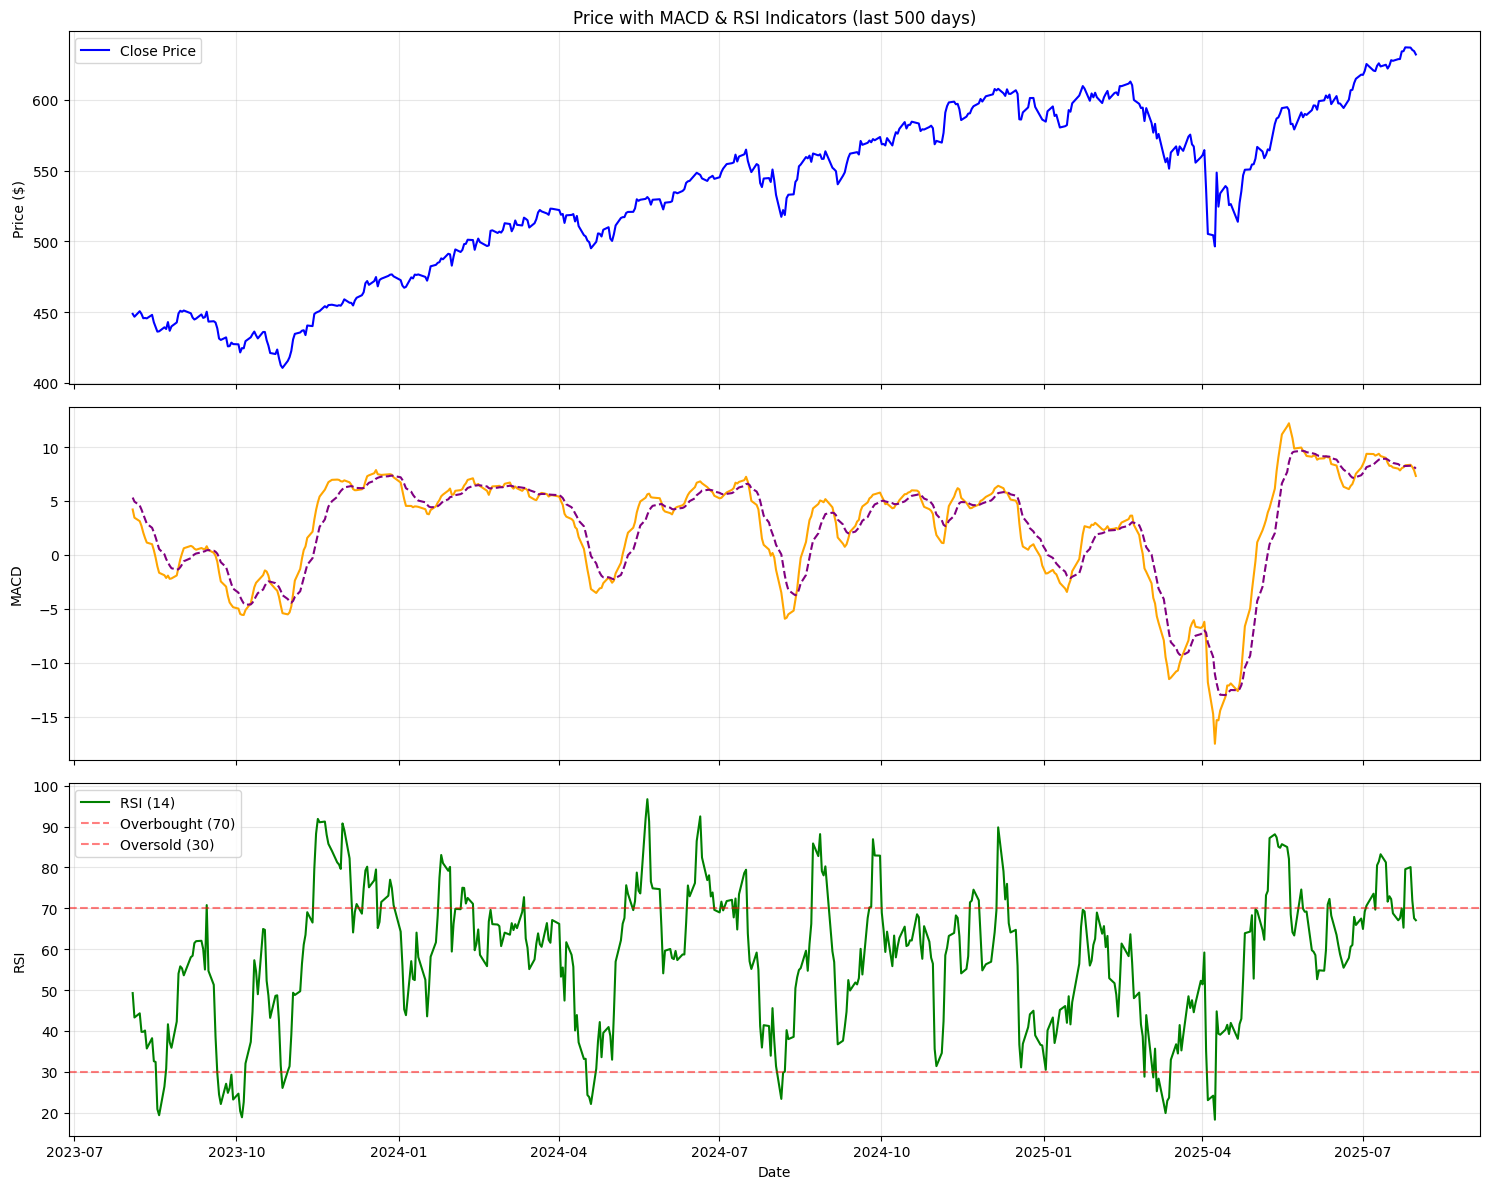

In [50]:
df_plot = df.tail(500)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15, 12), sharex=True)

# Price Plot
ax1.plot(df_plot.index, df_plot['close'], label='Close Price', color='blue')
ax1.set_title('Price with MACD & RSI Indicators (last 500 days)')
ax1.set_ylabel('Price ($)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# MACD Plot
ax2.plot(df_plot.index, df_plot['MACD'], label='MACD', color='orange')
ax2.plot(df_plot.index, df_plot['MACD_signal'], label='Signal Line', color='purple', linestyle='--')
ax2.set_ylabel('MACD')
ax2.grid(True, alpha=0.3)

# RSI Plot
ax3.plot(df_plot.index, df_plot['RSI_14'], label='RSI (14)', color='green')
ax3.axhline(70, color='red', linestyle='--', alpha=0.5, label='Overbought (70)')
ax3.axhline(30, color='red', linestyle='--', alpha=0.5, label='Oversold (30)')
ax3.set_ylabel('RSI')
ax3.set_xlabel('Date')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

#### 5.6.3 Feature Distribution

Histograms allow us to quickly check the distribution of our engineered features. This is a good check to ensure they fall within expected ranges (e.g., RSI between 0-100) and to spot any unusual skewness or outliers.

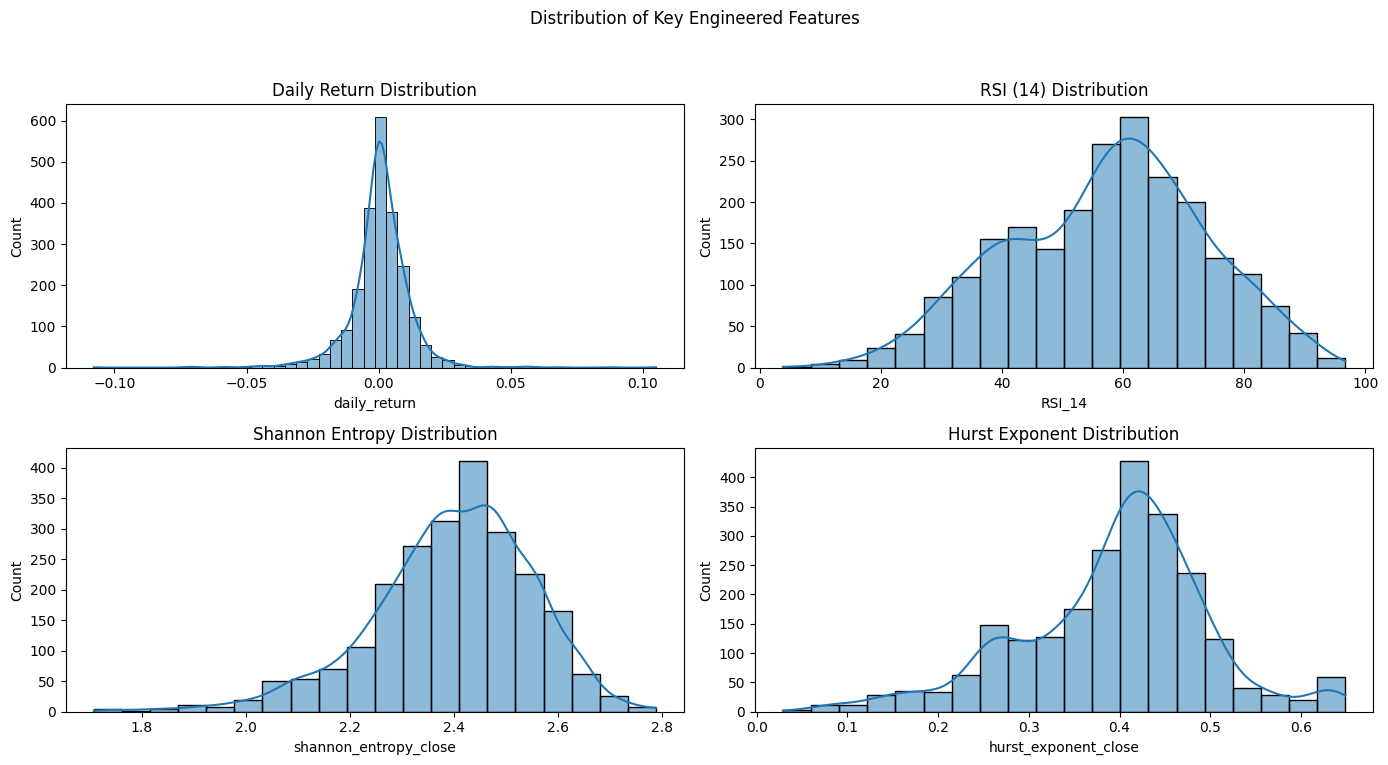

In [51]:
fig, axes = plt.subplots(2, 2, figsize=(14, 8))
fig.suptitle('Distribution of Key Engineered Features')

# Daily Return
sns.histplot(df['daily_return'], bins=50, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Daily Return Distribution')

# RSI_14
sns.histplot(df['RSI_14'], bins=20, kde=True, ax=axes[0, 1])
axes[0, 1].set_title('RSI (14) Distribution')

# Shannon Entropy
sns.histplot(df['shannon_entropy_close'], bins=20, kde=True, ax=axes[1, 0])
axes[1, 0].set_title('Shannon Entropy Distribution')

# Hurst Exponent
sns.histplot(df['hurst_exponent_close'], bins=20, kde=True, ax=axes[1, 1])
axes[1, 1].set_title('Hurst Exponent Distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## 6. Systematic Feature Selection
With over 40 engineered features, some will be valuable signals, while others will just noise. Feeding all of them into our LSTM can mask the real patterns, slow training, and hurt generalisation. To address this, we use a **Random Forest Regressor** to systematically score each feature's predictive power and select only the best ones.

### How it Works
A Random Forest is a "team" of many individual decision trees. Eaach tree is trained on a slightly different version of the dataset so the "team" can see multiple "views" of history. It works like this:
1. **Building Diverse Trees with Randomness** 
- **Random Data Sampling:** each tree sees a random sample of the historical data (with replacement). Tree #1's "view of history" isn't exactly the same as Tree #2's
- **Feature Subsampling:** at each decision point (node), the tree only considers a random subset of the available features, not all 40+ at once. This forces the forest to explore different combinations and prevents it from relying on just one dominant feature
2. **Finding the Best Split via Brute Force** 
- For each feature in the current subset, the tree tests potential split thresholds at the midpoints between the unique values in the sample
- For each candidate split, it calculates how much the variance of the target (next day's return) is reduced ni the resulting subgroups
- The split that most reduces variance is chosen - this means the data in each subgroup has returns that are more tightly clustered around their mean, which makes predictions more accurate
3. **Scoring Feature Importance** 
- Every time a feature is chosen for a split, the amount of variance it reduced is recorded
- These reductioins are averaged across all the splits in all the trees
- The final feature importance score tells us how much each feature helped the forest make accurate next-day return prediction

### Why This Matters for Our LSTM
Once the Random Forest is trained, we get a ranked list of features from most to least important. We then select only the top ones for our LSTM. This ensures our main model gets a cleaner, more powerful signal, making it easier to learn real market patterns and ignore noisy, irrelevant data. 

--- Data Shapes ---
X_train shape: (1846, 44)
X_test shape: (462, 44)
y_train shape: (1846,)
y_test shape: (462,)


/var/folders/l9/zmdgypk569x7yf8ttvk8fsbw0000gp/T/ipykernel_823/3806891095.py:35: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')


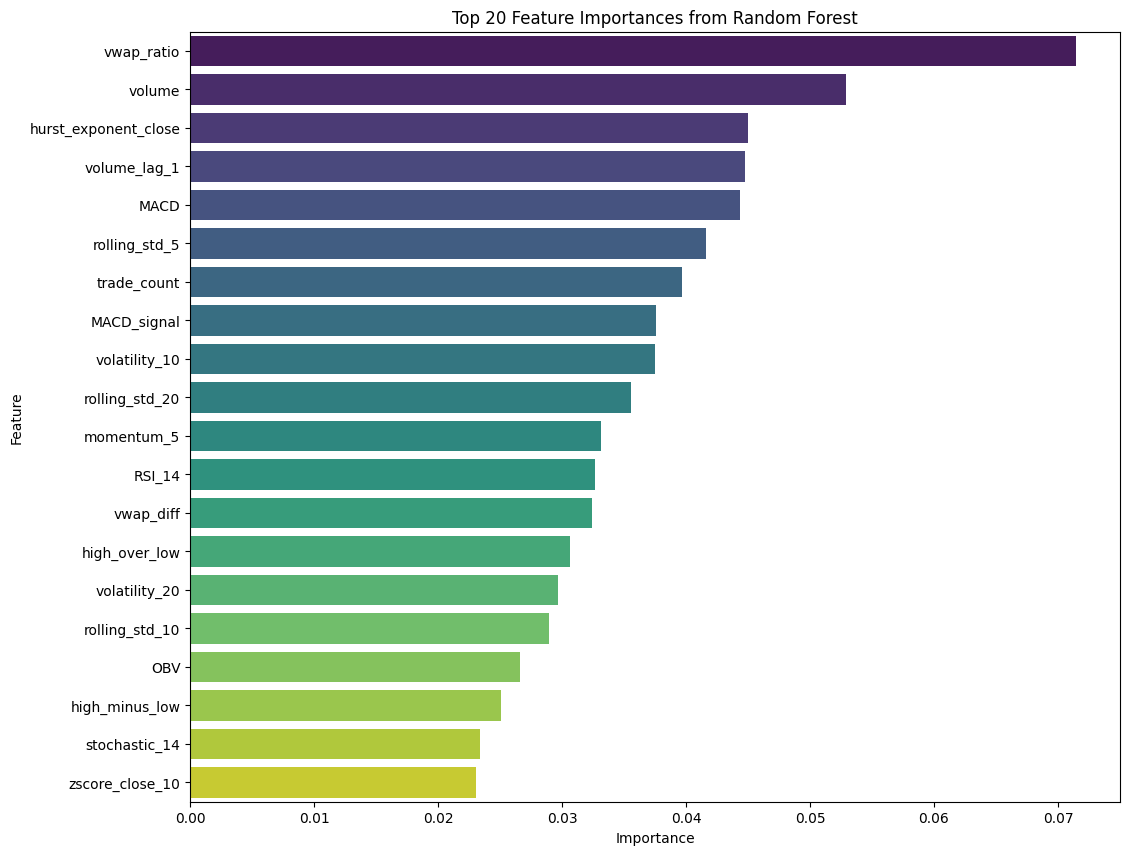


Top 20 Features Selected:
['vwap_ratio', 'volume', 'hurst_exponent_close', 'volume_lag_1', 'MACD', 'rolling_std_5', 'trade_count', 'MACD_signal', 'volatility_10', 'rolling_std_20', 'momentum_5', 'RSI_14', 'vwap_diff', 'high_over_low', 'volatility_20', 'rolling_std_10', 'OBV', 'high_minus_low', 'stochastic_14', 'zscore_close_10']

---Selected Features Shapes---
X_train_selected shape: (1846, 20)
X_test_selected shape: (462, 20)


In [ ]:
# Define features and the shifted target
features = df.drop(columns=['symbol','close','daily_return'])

# The target is the next day's return
target = df['daily_return'].shift(-1)

# Align data by removing NaNs created by shifting
features = features.iloc[:-1]
target = target.dropna()

# Ensure features and target are aligned after dropping NaNs
common_index = features.index.intersection(target.index)
X = features.loc[common_index]
y = target.loc[common_index]

# Split the data without shuffling to maintain the time series order
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("--- Data Shapes ---")
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")

# Initialize and train the Random Forest Regressor ONLY on the training data
rf = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf.fit(X_train, y_train)

# Extract feature importances from the trained model
importances = rf.feature_importances_
feature_names = X_train.columns
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(12, 10))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(20), palette='viridis')
plt.title('Top 20 Feature Importances from Random Forest')
plt.show()

# Select the top N features based on importance
N = 20 # Let's select the top 20 features
top_n_features = feature_importance_df.head(N)['Feature'].tolist()

print(f"\nTop {N} Features Selected:")
print(top_n_features)

X_train_selected = X_train[top_n_features]
X_test_selected = X_test[top_n_features]

print("\n---Selected Features Shapes---")
print("X_train_selected shape:", X_train_selected.shape)
print("X_test_selected shape:", X_test_selected.shape)

## 7. LSTM Model Architecture & Data Preparation
With the most predictive features identified, we can now prepare the dataset for our LSTM model and define its architecture. 
LSTMs work best when the input is sequential and scaled properly, so this stage involves:
1. Using only the top-ranked features from our Random Forest step
2. Splitting the dataset chronologically intro training, validation, and test sets
3. Scaling the features and target to standardise their ranges
4. Reshaping the data into overlapping sequences of historical obervations
5. Defining the LSTM network architecture that will learn from these sequences

### 7.1 Data Preparation

In [53]:
# Use only top N features from feature selection
features = top_n_features 
target_col = 'daily_return'

# Select only the necessary columns for the next steps
# We use the full df here to get the 'close' and 'daily_return' columns that were dropped earlier, before splitting it again chronologically
df_model = df[top_n_features + [target_col, 'close']].copy()

# Create the target by shifting daily_return
df_model[target_col] = df_model[target_col].shift(-1)

# Remove rows with NaNs from shifting
df_model.dropna(inplace=True)

### 7.2 Chronological Data Splitting
Unlike random splits, time-series data must be split in chronological order to prevent future data from leaking into the training phase. We reserve the last ~6 months for testing, and the ~6 months before that for validation.

In [54]:
sequence_length = 60 # Use 60 days of historical data per sequence
num_test_samples = 120 
num_val_samples = 120

# Check if there's enough data overall
if len(df_model) < num_test_samples + num_val_samples + sequence_length:
    raise ValueError(f"Not enough data for the specified splits. Need at least {num_test_samples + num_val_samples + sequence_length} samples, but have {len(df_model)}.")

# Split chronologically into Train, Validation, and Test sets
test_split_point = len(df_model) - num_test_samples
val_split_point = test_split_point - num_val_samples

train_df = df_model.iloc[:val_split_point]
val_df = df_model.iloc[val_split_point:test_split_point]
test_df = df_model.iloc[test_split_point:]

print(f"\nDataframe split sizes:")
print(f"Training set size: {len(train_df)}")
print(f"Validation set size: {len(val_df)}")
print(f"Test set size: {len(test_df)}")


Dataframe split sizes:
Training set size: 2068
Validation set size: 120
Test set size: 120


### 7.3 Scaling the Data
We standardise the features and target (mean = 0, std = 1) to speed up model convergence and ensure all features contribute equally. The scalers are fitted only on the training set to aviod data leakage.

In [55]:
# Initialise scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()    

# Fit scalers on training set only
feature_scaler.fit(train_df[features])
target_scaler.fit(train_df[[target_col]])

# Transform the datasets
X_train_scaled = feature_scaler.transform(train_df[features])
y_train_scaled = target_scaler.transform(train_df[[target_col]])

X_val_scaled = feature_scaler.transform(val_df[features])
y_val_scaled = target_scaler.transform(val_df[[target_col]])

X_test_scaled = feature_scaler.transform(test_df[features])
y_test_scaled = target_scaler.transform(test_df[[target_col]])

### 7.4 Creating Sequences for the LSTM
LSTMs require 3D inputs shaped as (samples, timesteps, features). We create overlapping sequences where each input contains the last 60 days of features, and the target is the return on the day immediately following that window

In [ ]:
def create_sequences(X, y, sequence_length=60):
    """
    Transforms time series data into overlapping sequences for LSTM input.
    """
    xs, ys = [], []
    for i in range(len(X) - sequence_length):
        xs.append(X[i:(i + sequence_length)]) # A sequence of features is from i to i+sequence_length
        ys.append(y[i + sequence_length - 1]) # The target is the value at the end of that sequence
    return np.array(xs), np.array(ys)

X_train, y_train = create_sequences(X_train_scaled, y_train_scaled, sequence_length)
X_val, y_val = create_sequences(X_val_scaled, y_val_scaled, sequence_length)
X_test, y_test = create_sequences(X_test_scaled, y_test_scaled, sequence_length)

print("\n--- Final Data Shapes for LSTM ---")
print(f"Shape of training data:X={X_train.shape}, y={y_train.shape}")
print(f"Shape of validation data:X={X_val.shape}, y={y_val.shape}")
print(f"Shape of test data:X={X_test.shape}, y={y_test.shape}")


--- Final Data Shapes for LSTM ---
Shape of training data:X=(2008, 60, 20), y=(2008, 1)
Shape of validation data:X=(60, 60, 20), y=(60, 1)
Shape of test data:X=(60, 60, 20), y=(60, 1)


### 7.5 LSTM Model Architecture
An LSTM network is built from a chain of LSTM cells.
Each cell has a **memory state** that retains information over long time spans, and a system of 3 gates that control what to remember, what to forget, and what to output.

Think of an LSTM cell as a smart worker on a data assembly line: it examines the data at one time step, updates its running memory, and passes the result to the next worker in line. The gates are the control switches that make this possible.

#### How the Gates Function
Each gate is a small neural network layer that uses a sigmoid function. This function acts like a filter, squashing any input value to a number between 0 (block everything) and 1 (let everything through).
- **Forget Gate - How it forgets:** 
The gate passes the current data and previous cell's output to a sigmoid filter. The result is a number between 0 and 1 for each piece of information in the long-term memory. This result is then multiplied by the long-term memory. Information is erased (if the filter value is 0), keeps it fully (if 1), or weakens its influence (if between 0 and 1).
- **Input Gate - How it stores new information:**
In a 2-step process, the gate first uses a sigmoid filter to identify which new information is important. It then multiplies this filter by a vector of all possible new information created by a tanh layer, ensuring that only the important new information is passed along to be stored.
- **Output Gate - How it creates the prediction:**
The gate uses its sigmoid filter to decide which parts of the updated long-term memory are relevant for a prediction right now. It then takes the long-term memory, passes it through a tanh function to scale it, and multiplies it by the sigmoid filter's output. This produces the final, filtered output for that time step.

By stacking cells, the network learns to tune these gates, automatically figuring out what to remember, ignore, and perdict based on the data. All of this complex architecture is efficiently managed by Keras in our model. 

In [57]:
# Define the LSTM model architecture
model = keras.models.Sequential([
    keras.layers.LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    keras.layers.Dropout(0.2),
    keras.layers.LSTM(50, return_sequences=False),
    keras.layers.Dropout(0.2),
    keras.layers.Dense(25, activation='relu'),
    keras.layers.Dense(1)  # Output layer for regression
])

model.summary()

/Users/khalid/Desktop/lstm-stock-prediction/venv/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_4 (LSTM)                   │ (None, 60, 100)        │        48,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 60, 100)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_5 (LSTM)                   │ (None, 50)             │        30,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 50)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 25)             │         1,275 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            26 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 79,901 (312.11 KB)

 Trainable params: 79,901 (312.11 KB)

 Non-trainable params: 0 (0.00 B)

## 8. Model Training

With the data prepared and the architecture defined, we'll now train our model.

We'll compile the model using the Adam optimizer with a low learning rate for stable convergence and Mean Squared Error (MSE) for our loss function.

To prevent overfitting, we employ early stopping. This technique monitors the validation loss and stops training if no improvement is seen after 10 epochs, ensuring we use the model's best performing weights.

In [68]:
# Compile the model 
optimizer = keras.optimizers.Adam(learning_rate=1e-5)
model.compile(optimizer=optimizer, loss='mse', metrics=[keras.metrics.RootMeanSquaredError()])

# Early stopping callback to avoid overfitting
early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Train the model
history = model.fit(
    X_train, y_train,
    epochs=150,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[early_stopping],
    verbose=1,
    shuffle=False
)

Epoch 1/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 0.7703 - root_mean_squared_error: 0.8488 - val_loss: 0.4793 - val_root_mean_squared_error: 0.6923
Epoch 2/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.7734 - root_mean_squared_error: 0.8498 - val_loss: 0.4795 - val_root_mean_squared_error: 0.6924
Epoch 3/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 56ms/step - loss: 0.7701 - root_mean_squared_error: 0.8481 - val_loss: 0.4795 - val_root_mean_squared_error: 0.6924
Epoch 4/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 54ms/step - loss: 0.7691 - root_mean_squared_error: 0.8485 - val_loss: 0.4794 - val_root_mean_squared_error: 0.6924
Epoch 5/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 4s 63ms/step - loss: 0.7698 - root_mean_squared_error: 0.8482 - val_loss: 0.4797 - val_root_mean_squared_error: 0.6926
Epoch 6/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 53ms/step - loss: 0.7670 - root_mean_squared_error: 0.8464 - val_loss: 0.4799 - val_root_mean_squared_error: 0.6928
Epoch 7/150
63/63 ━━━━━━━━━━━━━━━━━━━━ 3s 55ms/step 

## 9. Results & Diagnostics
With the model trained, this section proides a visual and statistical assessment of its performance.
We evaluate the model in 3 complementary ways - returns, anchored prices, and chained prices - because each lens highlights different behaviours (signal quality vs. error propagation). 
We then inspect residuals and the training/validation loss to check for bias and overfitting.

### 9.1 Performance Evaluation
We evaluate the model on the unseen test set using 3 diagnostic approaches:
 1. **Return Prediction -** the model directly predicts daily returns, which are then compared to actual returns. This is the most direct measure of prediction skill but ignores price compounding effects.
 2. **Anchored Price Evaluation -** starting from the first known test set price, predicted returns are compounded forward to reconstruct predicted prices. This avoids compounding earlier prediction errors into later forecasts, offering a stable view of accuracy over the test period.
 3. **Chained Price Evaluation -** predictions are chained day-by-day, with each day's predicted price feeding into the next step. This simulates a real deployment where only past predictions and actuals are available, but can amplify small early errors into large divergences

 These complementary views allow us to see not only how well the model predicts returns, but also how prediction errors translate into price forecasts over time.

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step

[Returns Evaluation]
MAE : 0.005217
RMSE: 0.007324
R^2 : 0.007486
MAPE: 135.3467%
Directional accuracy: 60.00%


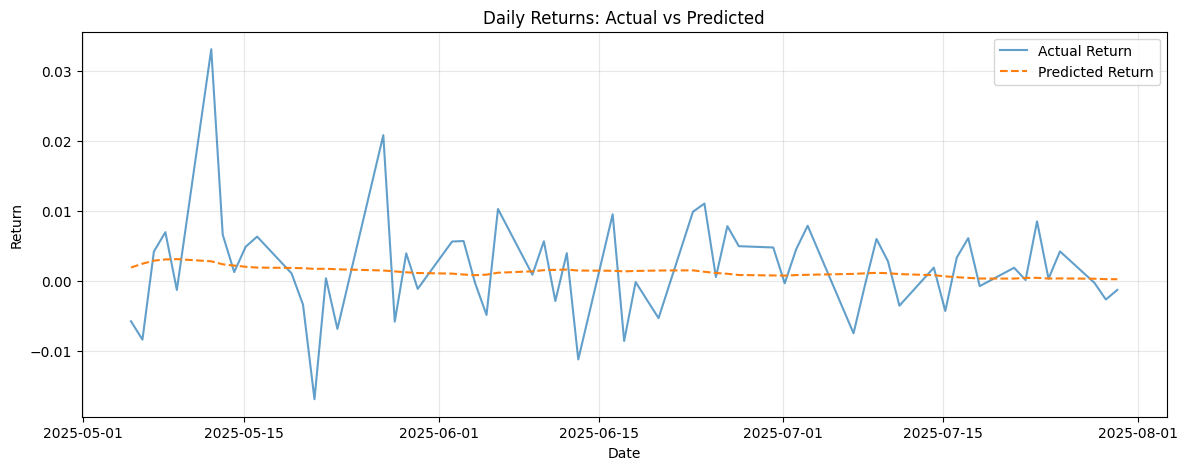

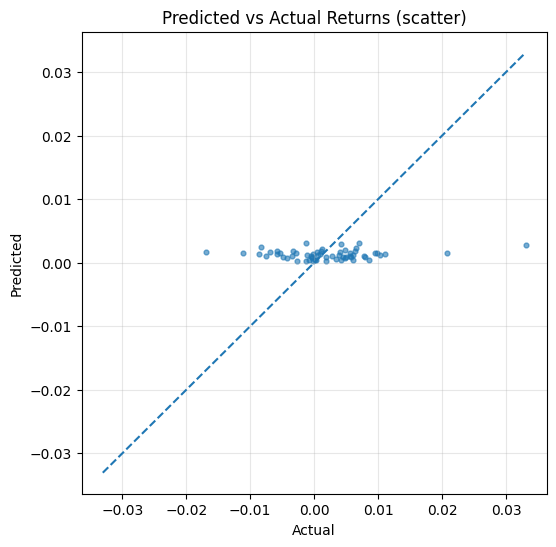


[Anchored Price Evaluation] (diagnostic / optimistic)
MAE : 3.106793
RMSE: 4.295800
R^2 : 0.956884
MAPE: 0.5196%


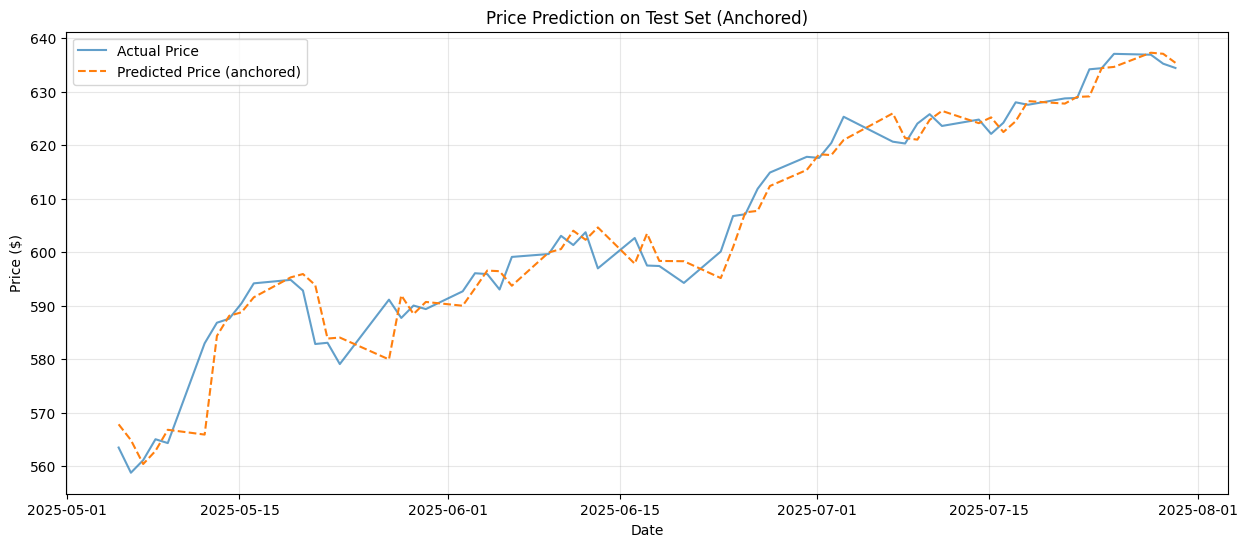


[Chained Price Evaluation] (realistic / compounding)
MAE : 10.285334
RMSE: 12.349153
R^2 : 0.643696
MAPE: 1.6766%


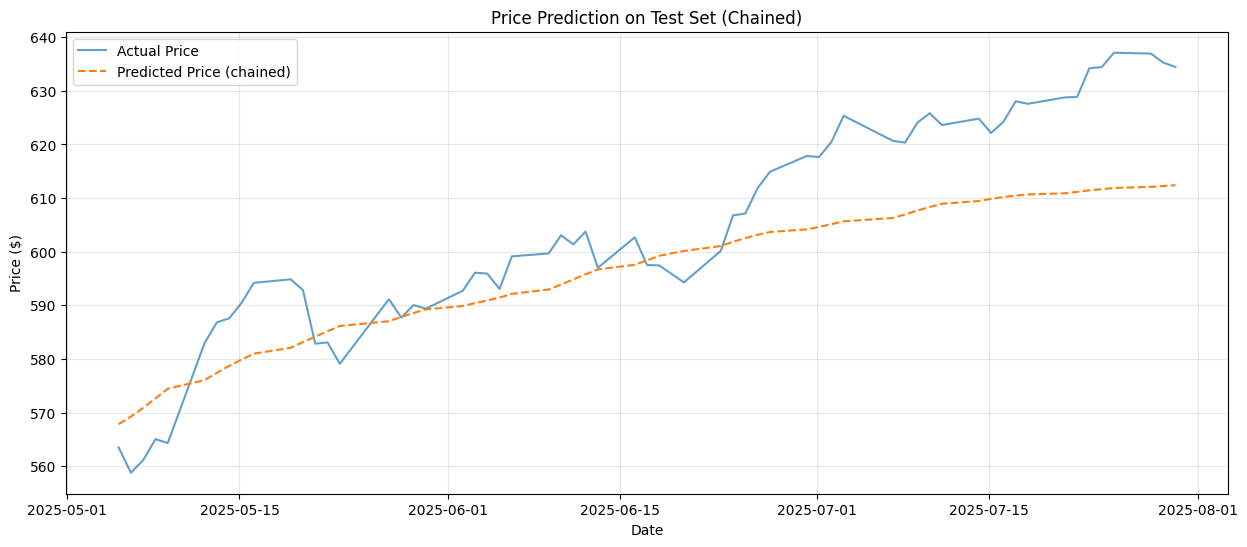


Summary of key metrics:
    Eval       MAE      RMSE      R^2 MAPE (%) Directional Accuracy (%)
 Returns  0.005217  0.007324 0.007486   135.35                    60.00
Anchored  3.106793  4.295800 0.956884     0.52                      NaN
 Chained 10.285334 12.349153 0.643696     1.68                      NaN


In [78]:
# Predict the scaled returns on the test set 
pred_scaled = model.predict(X_test) 

# Invert scaling to get actual returns 
pred_returns = target_scaler.inverse_transform(pred_scaled) 
actual_returns = target_scaler.inverse_transform(y_test)

n_preds = pred_returns.shape[0]
start = test_split_point + sequence_length - 1

# Dates aligned to predictions (t+1 .. t+n)
test_dates = df_model.index[start + 1 : start + 1 + n_preds]

# True prices for those dates
true_prices = df_model['close'].iloc[start + 1 : start + 1 + n_preds].values

# RETURN PREDICTION 
returns_mae  = mean_absolute_error(actual_returns, pred_returns)
returns_rmse = np.sqrt(mean_squared_error(actual_returns, pred_returns))
returns_r2   = r2_score(actual_returns, pred_returns)
returns_mape = np.mean(np.abs((actual_returns - pred_returns) / np.where(actual_returns == 0, 1e-8, actual_returns))) * 100
returns_dir  = (np.sign(pred_returns.flatten()) == np.sign(actual_returns.flatten())).mean() * 100

print("\n[Returns Evaluation]")
print(f"MAE : {returns_mae:.6f}")
print(f"RMSE: {returns_rmse:.6f}")
print(f"R^2 : {returns_r2:.6f}")
print(f"MAPE: {returns_mape:.4f}%")
print(f"Directional accuracy: {returns_dir:.2f}%")

# Plot: actual vs predicted returns over time
plt.figure(figsize=(14, 5))
plt.plot(test_dates, actual_returns.flatten(), label='Actual Return', alpha=0.7)
plt.plot(test_dates, pred_returns.flatten(),   label='Predicted Return', linestyle='--')
plt.title('Daily Returns: Actual vs Predicted')
plt.xlabel('Date'); plt.ylabel('Return')
plt.legend(); plt.grid(True, alpha=0.3)
plt.show()

# Plot: scatter of predicted vs actual returns (with y=x reference)
plt.figure(figsize=(6, 6))
plt.scatter(actual_returns.flatten(), pred_returns.flatten(), s=12, alpha=0.6)
min_ax = float(np.min(actual_returns))
max_ax = float(np.max(actual_returns))
lim = max(abs(min_ax), abs(max_ax))
plt.plot([-lim, lim], [-lim, lim], linestyle='--')
plt.title('Predicted vs Actual Returns (scatter)')
plt.xlabel('Actual'); plt.ylabel('Predicted')
plt.grid(True, alpha=0.3)
plt.show()

# ANCHORED PRICE
last_known_prices = df_model['close'].iloc[start : start + n_preds].values
predicted_prices_anchored = last_known_prices * (1 + pred_returns.flatten())

mae_a  = mean_absolute_error(true_prices, predicted_prices_anchored)
rmse_a = np.sqrt(mean_squared_error(true_prices, predicted_prices_anchored))
r2_a   = r2_score(true_prices, predicted_prices_anchored)
mape_a = np.mean(np.abs((true_prices - predicted_prices_anchored) / np.where(true_prices == 0, 1e-8, true_prices))) * 100

print("\n[Anchored Price Evaluation] (diagnostic / optimistic)")
print(f"MAE : {mae_a:.6f}")
print(f"RMSE: {rmse_a:.6f}")
print(f"R^2 : {r2_a:.6f}")
print(f"MAPE: {mape_a:.4f}%")

plt.figure(figsize=(15, 6))
plt.plot(test_dates, true_prices, label='Actual Price', alpha=0.7)
plt.plot(test_dates, predicted_prices_anchored, label='Predicted Price (anchored)', linestyle='--')
plt.title('Price Prediction on Test Set (Anchored)')
plt.xlabel('Date'); plt.ylabel('Price ($)')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# CHAINED PRICE
anchor_price = df_model['close'].iloc[start]
p = anchor_price
chain = []
for r in pred_returns.flatten():
    p *= (1 + r)  # Compounding the returns
    chain.append(p)
predicted_prices_chained = np.array(chain)

mae_c  = mean_absolute_error(true_prices, predicted_prices_chained)
rmse_c = np.sqrt(mean_squared_error(true_prices, predicted_prices_chained))
r2_c   = r2_score(true_prices, predicted_prices_chained)
mape_c = np.mean(np.abs((true_prices - predicted_prices_chained) / np.where(true_prices == 0, 1e-8, true_prices))) * 100

print("\n[Chained Price Evaluation] (realistic / compounding)")
print(f"MAE : {mae_c:.6f}")
print(f"RMSE: {rmse_c:.6f}")
print(f"R^2 : {r2_c:.6f}")
print(f"MAPE: {mape_c:.4f}%")

plt.figure(figsize=(15, 6))
plt.plot(test_dates, true_prices,               label='Actual Price', alpha=0.7)
plt.plot(test_dates, predicted_prices_chained,  label='Predicted Price (chained)', linestyle='--')
plt.title('Price Prediction on Test Set (Chained)')
plt.xlabel('Date'); plt.ylabel('Price ($)')
plt.legend(); plt.grid(True, alpha=0.3); plt.show()

# Summary table
summary = pd.DataFrame([
    ["Returns",  returns_mae, returns_rmse, returns_r2, returns_mape, returns_dir],
    ["Anchored", mae_a,       rmse_a,       r2_a,       mape_a,       np.nan     ],
    ["Chained",  mae_c,       rmse_c,       r2_c,       mape_c,       np.nan     ],
], columns=["Eval", "MAE", "RMSE", "R^2", "MAPE (%)", "Directional Accuracy (%)"])

print("\nSummary of key metrics:")

def _show_summary(df: pd.DataFrame):
    # Try Styler first (requires jinja2)
    try:
        _ = df.style  # will raise if jinja2 missing
        display(
            df.style.format({
                "MAE": "{:.6f}",
                "RMSE": "{:.6f}",
                "R^2": "{:.6f}",
                "MAPE (%)": "{:.2f}",
                "Directional Accuracy (%)": "{:.2f}",
            })
        )
    except Exception:
        # Plain-text fallback with formatters
        fmts = {
            "MAE": lambda x: f"{x:.6f}" if pd.notna(x) else "",
            "RMSE": lambda x: f"{x:.6f}" if pd.notna(x) else "",
            "R^2": lambda x: f"{x:.6f}" if pd.notna(x) else "",
            "MAPE (%)": lambda x: f"{x:.2f}" if pd.notna(x) else "",
            "Directional Accuracy (%)": lambda x: f"{x:.2f}" if pd.notna(x) else "",
        }
        print(df.to_string(index=False, formatters=fmts))

_show_summary(summary)

### 9.2 Residuals Analysis (anchored by default)
Residuals are errors = actual - predicted. We want them to look like random noise (no pattern over time), centered around zero, with roughly symmetric distribution. Systematic patterns imply the model is missing structure (e.g., regime shifts).

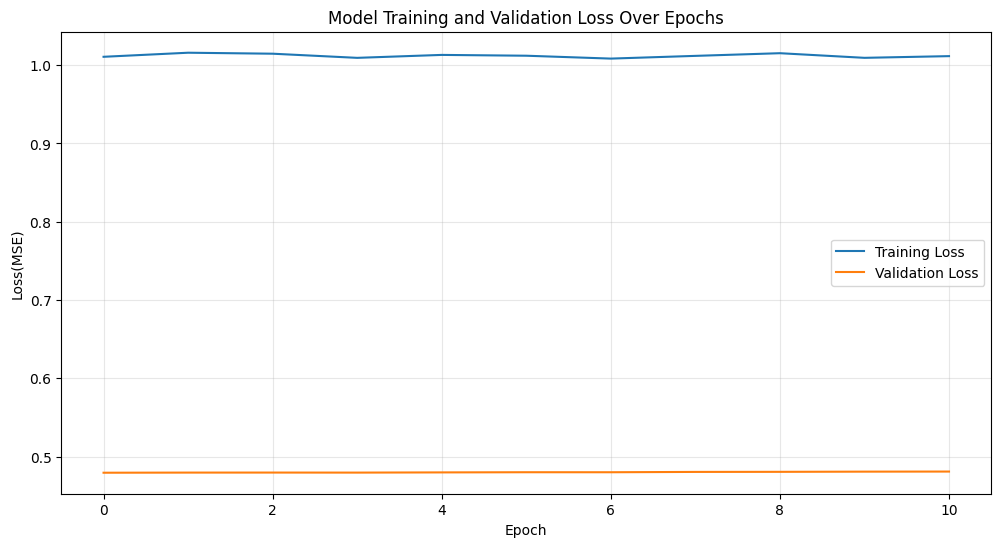

In [ ]:
# Use anchored residuals by default
residuals = true_prices - predicted_prices_anchored

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Residuals over time
ax1.plot(test_dates, residuals)
ax1.set_title('Prediction Residuals Over Time (Anchored)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Error ($)')
ax1.grid(True, alpha=0.3)

# Distribution of residuals
sns.histplot(residuals, bins=30, kde=True, ax=ax2)
ax2.set_title('Distribution of Residuals (Anchored)')
ax2.set_xlabel('Error ($)')
ax2.set_ylabel('Frequency')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nStatistical Summary of Residuals (Anchored):")
print(pd.Series(residuals).describe())

### 9.3 Training & Validation Loss (Overfitting Check)
We monitor training vs validation loss to ensure generalisation. Divergence (training loss decreases while validation loss increases) is a red flag; EarlyStopping should have stopped near the best validation loss.

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot((history.history.get('loss') or []), label='Training Loss')

if 'val_loss' in history.history:
    plt.plot(history.history['val_loss'], label='Validation Loss')

plt.title('Model Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### 9.4 Rolling Directional Accuracy (Signal Stability)
A rolling hit-rate shows whether the model's reliability is consistent or regime-dependent.

In [ ]:
# Rolling directional accuracy over a 20-day window
window = 20
hits = (np.sign(pred_returns.flatten()) == np.sign(actual_returns.flatten())).astype(int)
rolling_acc = pd.Series(hits, index=test_dates).rolling(window).mean() * 100

plt.figure(figsize=(12, 4))
plt.plot(rolling_acc)
plt.title(f'Rolling {window}-Day Directional Accuracy')
plt.xlabel('Date'); plt.ylabel('Hit Rate (%)')
plt.grid(True, alpha=0.3)
plt.ylim(0, 100)
plt.show()

## 10. Finale: Findings, Limitations & Next Steps

### 10.1 Summary of What We Built
This project assembled a **time‑series forecasting pipeline** for SPY daily data:
- Retrieved and cleaned OHLCV via Alpaca; engineered **price/ratio/volatility**, **technical indicators** (SMA/EMA, RSI, MACD, Bollinger), plus **statistical** features (Shannon entropy, Hurst exponent, ACF).
- Performed **time‑aware feature selection** with a Random Forest to identify the most informative signals for next‑day returns.
- Prepared **chronological train/val/test splits**, fit scalers on **train only** to avoid leakage, and created **fixed‑length sequences** for the LSTM.
- Trained a **2-layer LSTM** with dropout and early stopping; evaluated both **return prediction metrics** and **price diagnostics** (anchored and chained paths), plus **directional accuracy**, **residuals**, and **stability**.

### 10.2 Key Takeaways (Interpretation)
- **Return predictions** show a very small R² (~0.0075) — expected in a near-efficient market — but a **directional accuracy of ~60%** suggests the model captures some signal in predicting the sign of returns, even if magnitude predictions are noisy.  
- **Anchored price path** reconstruction yields a high R² (~0.957) and low MAPE (~0.52%), but this is partly an artefact of using the last known actual price each step — it’s optimistic and less representative of real deployment.  
- **Chained price path**, which compounds predicted returns without resetting to actuals, shows more realistic performance: R² drops to ~0.644 and errors are larger (MAE ~10.29, RMSE ~12.35). This better reflects the model’s live trading performance, where prediction errors accumulate.  
- **Magnitude vs. direction**: While predicting exact next-day returns remains challenging (high MAPE in returns), the directional edge could be exploitable in a strategy with good risk management.  

Overall, the model appears better suited for **trend direction signalling** rather than precise return magnitude forecasting.

### 10.3 Limitations & Risks
- **Non‑stationarity / regime shifts**: Relationships change across time (macro cycles, volatility regimes). A static model can decay quickly without **walk‑forward re‑training**.
- **Label definition**: Next‑day return may be too noisy; alternative horizons (e.g., 5‑day) or targets (e.g., **directional** labels) could be more learnable.
- **Evaluation bias**: Anchored price diagnostics can look optimistic; **chained** paths are more realistic and should be emphasised.
- **Data coverage**: Using only SPY daily bars leaves **news/macro/term structure** unexplored; edge likely improves with richer context.

### 10.4 Next Steps (High‑Impact First)
1. **Walk‑Forward Validation**  
   Switch to rolling-window training & evaluation (expand/slide) to mimic live deployment. Log metrics over each window.
2. **Hyperparameter Search**  
   Tune sequence length, hidden sizes, dropout, learning rate, and batch size (e.g., KerasTuner or Optuna). Start LR at 1e‑3/1e‑4.
3. **Targets & Horizons**  
   Try directional targets (`sign(return)`) and multi‑horizon returns (e.g., 1/3/5 day). Compare hit rate, precision/recall, and calibration.
4. **Features**  
   Add **trend/vol regime flags**, **market breadth**, **term structure** (VIX term, yield curve), **seasonality dummies**, and **macro surprise** proxies. Re‑run selection.
5. **Baselines & Ensembling**  
   Add simple baselines (zero‑return, yesterday’s sign, SMA crossover), linear/elastic‑net, XGBoost/LightGBM, and a TCN. Consider simple **averaging or stacking**.
6. **Robustness & Stability**  
   Bootstrap test periods, compute **confidence intervals** for metrics, and add **drift detection** (e.g., PSI) to know when to retrain.
7. **Reproducibility & Ops**  
   Seed everything (NumPy/TF/Python), log versions, and save the **scalers + model** artifacts. Add a small **inference notebook**.
